In [1]:
import pydotplus
import pandas as pd
import numpy as np
from io import StringIO
# from sklearn.externals.six import StringIO
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from classes import BalancedUndersamplingShuffle, balanced_sampling
from helpers import plot_learning_curve, plot_validation_curve, plot_validation_curve_with_undersampling, \
    plot_validation_curve_with_undersampling, fit_and_score_iteratively
from sklearn.metrics import check_scoring
from sklearn.model_selection._validation import _fit_and_score
from sklearn.model_selection import ShuffleSplit, StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import fbeta_score, make_scorer
import matplotlib.pyplot as plt

In [2]:
from scipy.io import arff

with open('1year.arff','r') as f:
    data1, meta1 = arff.loadarff(f)
    data1 = np.asarray(data1.tolist(), dtype=np.float32)
    print(data1.shape)

with open('2year.arff','r') as f:
    data2, meta2 = arff.loadarff(f)
    data2 = np.asarray(data2.tolist(), dtype=np.float32)
    print(data2.shape)

with open('3year.arff','r') as f:
    data3, meta3 = arff.loadarff(f)
    data3 = np.asarray(data3.tolist(), dtype=np.float32)
    print(data3.shape)

with open('4year.arff','r') as f:
    data4, meta4 = arff.loadarff(f)
    data4 = np.asarray(data4.tolist(), dtype=np.float32)
    print(data4.shape)

with open('5year.arff','r') as f:
    data5, meta5 = arff.loadarff(f)
    data5 = np.asarray(data5.tolist(), dtype=np.float32)
    print(data5.shape)


(7027, 65)
(10173, 65)
(10503, 65)
(9792, 65)
(5910, 65)


In [3]:
data = np.concatenate([data1, data2, data3, data4, data5], axis=0)
data[np.isnan(data)] = 0

minority_class_shape = data[data[:,-1]==1].shape
print(f'label=1 shape = {minority_class_shape}')
print(f'label=1 pct = {minority_class_shape[0]/data.shape[0]}')


# 
# drop_columns = [23, ]
# convert_nan_to_0_cols = [4, 26, 36, 44, 59]

# replace column i = 36 nans with 0's
# for i in convert_nan_to_0_cols:
#     col = data[:, i]
#     col[np.isnan(col)] = 0
#     print(f'col36 nans={np.count_nonzero(np.isnan(data[:,36]))}')


# data = np.delete(data, drop_columns, axis=1)
# print(np.count_nonzero(np.isnan(data), axis=0))
# print(data.shape)

# print(f'dropped = {dropped.shape}')
# print(np.isnan(data).any(axis=1))
# nans = data[np.isnan(data).any(axis=1)]
# data = data[~np.isnan(data).any(axis=1)]

# print(f'label=1 shape after dropping = {data[data[:,-1]==1].shape}')
# _data = np.copy(data)
# _data[:, 0] = _data[:, 1]
# print(f'0= {_data[:, 0]}')
# print(f'1= {_data[:, 1]}')
# print(f'_data={_data}')

# print(f'data.shape={data.shape}')

X, y = data[:,:-1], data[:, -1]

print(f'X.shape={X.shape}, y.shape={y.shape}')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


label=1 shape = (2091, 65)
label=1 pct = 0.04817417348231771
X.shape=(43405, 64), y.shape=(43405,)


In [ ]:
# no undersampling - gini

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


# Baseline model
classifier = DecisionTreeClassifier(random_state=0, criterion='gini')
classifier.fit(X_train, y_train)

scorer = check_scoring(classifier, scoring='f1')
print(f'f1 score = {scorer(classifier, X_test, y_test)}')

scorer = check_scoring(classifier, scoring='accuracy')
print(f'accuracy score = {scorer(classifier, X_test, y_test)}')

scorer = check_scoring(classifier, scoring='recall')
print(f'recall score = {scorer(classifier, X_test, y_test)}')

scorer = check_scoring(classifier, scoring='precision')
print(f'precision score = {scorer(classifier, X_test, y_test)}')

scorer = check_scoring(classifier, scoring='balanced_accuracy')
print(f'balanced accuracy score = {scorer(classifier, X_test, y_test)}')

print(f'max_depth = {classifier.get_depth()}')
print(f'number of leaves = {classifier.get_n_leaves()}')

## Hyperparameter tuning

### max_depth

a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a

a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a

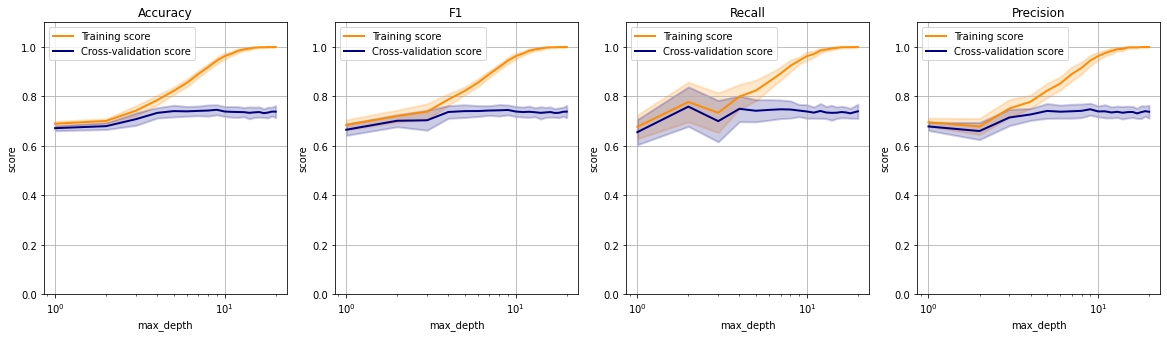

In [4]:
# max_depth - accuracy
X_, y_, idx = balanced_sampling(X, y, r = 1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.3, random_state=42, stratify=y_)

scoring = ['accuracy', 'f1', 'recall', 'precision']
param_range = range(1, 21, 1)
classifier = DecisionTreeClassifier(random_state=0, criterion='gini')
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=0)
results_store, plt = plot_validation_curve_with_undersampling(classifier, X_train, y_train, 
                      param_name='max_depth', param_range=param_range, fit_params=None, error_score='raise',
                      cv=cv, scoring=scoring, n_jobs=8, iterations=20, undersampling_ratio=1)


In [12]:
optimal_max_depth = results_store.copy()
for k, v in optimal_max_depth.items():
    optimal_max_depth[k] = param_range[np.argmax(v[:, 1])]
optimal_max_depth

{'fit_time': 18,
 'score_time': 18,
 'test_accuracy': 9,
 'train_accuracy': 20,
 'test_f1': 9,
 'train_f1': 20,
 'test_recall': 2,
 'train_recall': 20,
 'test_precision': 9,
 'train_precision': 20}

In [5]:
# Undersampling
# Baseline model
classifier = DecisionTreeClassifier(random_state=0, criterion='gini', max_depth=9)
res = fit_and_score_iteratively(classifier, X, y, 1, 10)
print(res)

a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
[0.78621514 0.78769358 0.78154167 0.79425837 0.78622154]


### min_samples_split

param=2
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
param=4
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
param=6
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, ga

a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
param=46
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
param=48
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
param=50
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1,

a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
param=90
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
param=92
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
param=94
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1,

a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
param=270
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
param=280
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=

a=0.0, r=1, gamma=19.753415300546447
param=480
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
param=490
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447


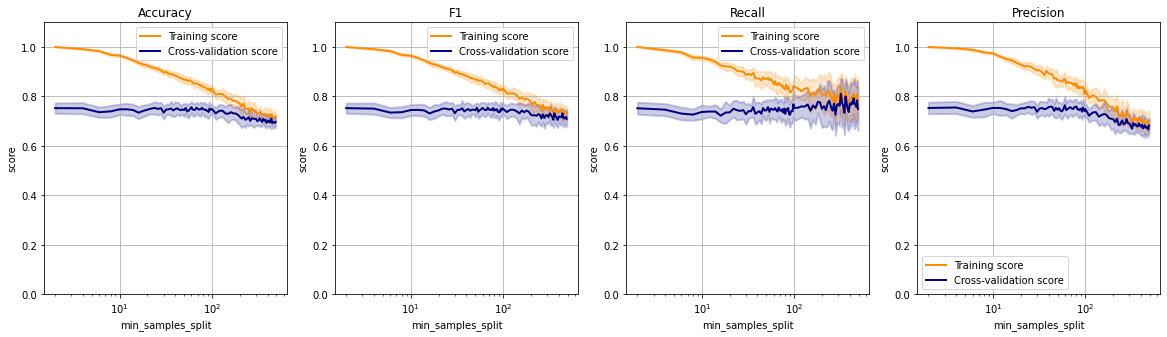

In [10]:
# min_samples_split
scoring = ['accuracy', 'f1', 'recall', 'precision']
param_range = list(range(2, 100, 2)) + list(range(100, 500, 10))
classifier = DecisionTreeClassifier(random_state=0, criterion='gini', max_depth=None)
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=0)
results_store, plt = plot_validation_curve_with_undersampling(classifier, X_train, y_train, 
                      param_name='min_samples_split', param_range=param_range, fit_params=None, error_score='raise',
                      cv=cv, scoring=scoring, n_jobs=8, iterations=10, undersampling_ratio=1)


In [11]:
print(results_store)

{'fit_time': array([[2.00000000e+00, 1.02664959e-01, 6.69739078e-02],
       [4.00000000e+00, 1.50617707e-01, 1.15115238e-01],
       [6.00000000e+00, 1.34952092e-01, 9.12688185e-02],
       [8.00000000e+00, 8.24673176e-02, 8.55976668e-03],
       [1.00000000e+01, 9.76968408e-02, 4.34361731e-02],
       [1.20000000e+01, 1.82170618e-01, 1.03024588e-01],
       [1.40000000e+01, 8.29190135e-02, 7.60549153e-03],
       [1.60000000e+01, 8.29677224e-02, 9.80561021e-03],
       [1.80000000e+01, 1.94897819e-01, 1.05198420e-01],
       [2.00000000e+01, 8.08282614e-02, 9.03396535e-03],
       [2.20000000e+01, 8.58196974e-02, 1.75938452e-02],
       [2.40000000e+01, 1.80532551e-01, 1.02162207e-01],
       [2.60000000e+01, 9.16237831e-02, 2.53118371e-02],
       [2.80000000e+01, 8.17987084e-02, 9.05386940e-03],
       [3.00000000e+01, 1.42720425e-01, 8.57534289e-02],
       [3.20000000e+01, 1.38622272e-01, 9.64163003e-02],
       [3.40000000e+01, 7.94184685e-02, 7.60382333e-03],
       [3.60000000

In [6]:
# Undersampling to a 3:1 ratio
# Baseline model
classifier = DecisionTreeClassifier(random_state=0, criterion='gini', min_samples_split=10)
res = fit_and_score_iteratively(classifier, X, y, 1, 10)
print(res)

a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
[0.76828685 0.76804383 0.76836144 0.76794258 0.76828658]


param=0.0
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
param=0.01
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
param=0.02
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0,

/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn

a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn

param=0.08
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn

a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
param=0.09
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn

a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
param=0.1
a=0.0, r=1, gamma=19.753415300546447


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn

a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn

a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447


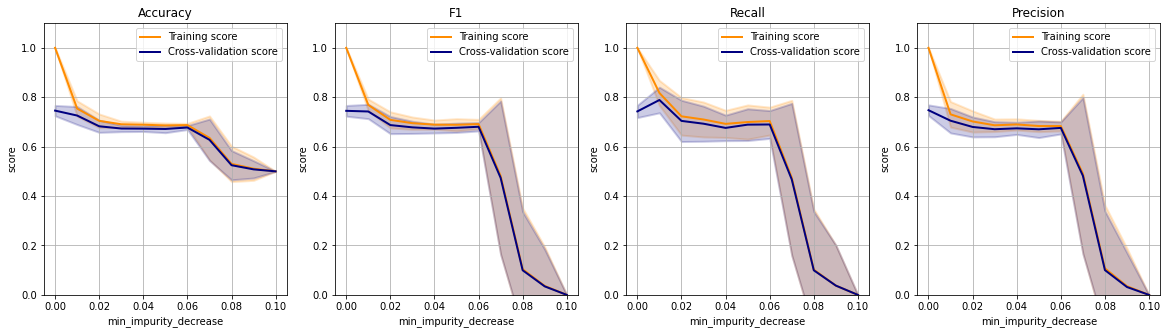

In [4]:
# min_impurity_decrease
scoring = ['accuracy', 'f1', 'recall', 'precision']
param_range = [ x*0.01 for x in range(0, 11)]
classifier = DecisionTreeClassifier(random_state=0, criterion='gini', max_depth=None)
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=0)
results_store, plt = plot_validation_curve_with_undersampling(classifier, X_train, y_train, 
                      param_name='min_impurity_decrease', param_range=param_range, fit_params=None, error_score='raise',
                      cv=cv, scoring=scoring, n_jobs=8, iterations=10, undersampling_ratio=1, x_axis_is_log=False)


In [15]:
optimal_min_samples_split = results_store.copy()
for k, v in optimal_min_samples_split.items():
    optimal_min_samples_split[k] = param_range[np.argmax(v[:, 1])]
optimal_min_samples_split

{'fit_time': 32,
 'score_time': 70,
 'test_accuracy': 68,
 'train_accuracy': 2,
 'test_f1': 66,
 'train_f1': 2,
 'test_recall': 80,
 'train_recall': 2,
 'test_precision': 14,
 'train_precision': 2}

In [12]:
results_store

{'fit_time': array([[2.00000000e+00, 1.02664959e-01, 6.69739078e-02],
        [4.00000000e+00, 1.50617707e-01, 1.15115238e-01],
        [6.00000000e+00, 1.34952092e-01, 9.12688185e-02],
        [8.00000000e+00, 8.24673176e-02, 8.55976668e-03],
        [1.00000000e+01, 9.76968408e-02, 4.34361731e-02],
        [1.20000000e+01, 1.82170618e-01, 1.03024588e-01],
        [1.40000000e+01, 8.29190135e-02, 7.60549153e-03],
        [1.60000000e+01, 8.29677224e-02, 9.80561021e-03],
        [1.80000000e+01, 1.94897819e-01, 1.05198420e-01],
        [2.00000000e+01, 8.08282614e-02, 9.03396535e-03],
        [2.20000000e+01, 8.58196974e-02, 1.75938452e-02],
        [2.40000000e+01, 1.80532551e-01, 1.02162207e-01],
        [2.60000000e+01, 9.16237831e-02, 2.53118371e-02],
        [2.80000000e+01, 8.17987084e-02, 9.05386940e-03],
        [3.00000000e+01, 1.42720425e-01, 8.57534289e-02],
        [3.20000000e+01, 1.38622272e-01, 9.64163003e-02],
        [3.40000000e+01, 7.94184685e-02, 7.60382333e-03],
  

### min_samples_leaf

param=2
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
param=4
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.7

a=0.0, r=1, gamma=19.753415300546447
param=24
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
param=26
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19

a=0.0, r=1, gamma=19.753415300546447
param=46
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
param=48
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19

a=0.0, r=1, gamma=19.753415300546447
param=68
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
param=70
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19

a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
param=90
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
param=92
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19.753415300546447
a=0.0, r=1, gamma=19

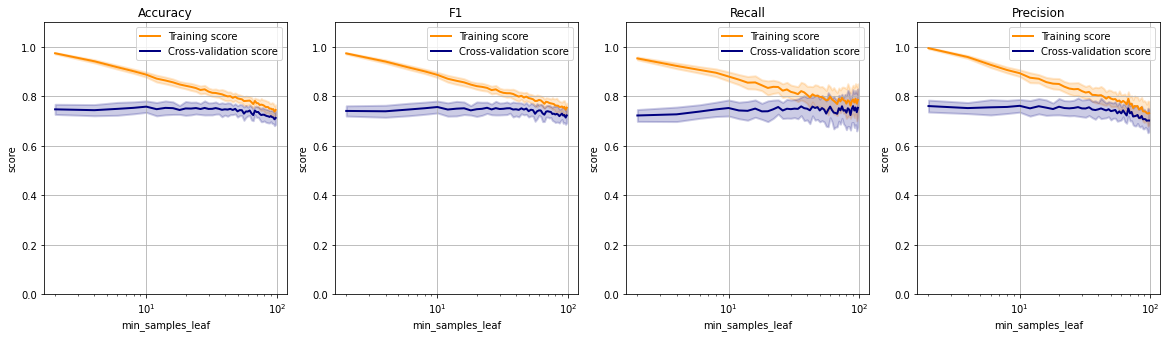

In [7]:
# min_samples_leaf
scoring = ['accuracy', 'f1', 'recall', 'precision']
param_range = range(2, 100, 2)
classifier = DecisionTreeClassifier(random_state=0, criterion='gini')
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=0)
results_store, plt = plot_validation_curve_with_undersampling(classifier, X_train, y_train, 
                      param_name='min_samples_leaf', param_range=param_range, fit_params=None, error_score='raise',
                      cv=cv, scoring=scoring, n_jobs=8, iterations=20, undersampling_ratio=1)


In [8]:
print(results_store)

{'fit_time': array([[2.00000000e+00, 9.76117432e-02, 5.53603917e-02],
       [4.00000000e+00, 1.24001968e-01, 8.32644803e-02],
       [6.00000000e+00, 1.26964664e-01, 8.56220653e-02],
       [8.00000000e+00, 6.94081485e-02, 8.43047051e-03],
       [1.00000000e+01, 1.21691352e-01, 7.92350098e-02],
       [1.20000000e+01, 6.36514366e-02, 7.17580972e-03],
       [1.40000000e+01, 1.15505838e-01, 8.07258478e-02],
       [1.60000000e+01, 6.19867206e-02, 7.76539560e-03],
       [1.80000000e+01, 1.14598852e-01, 7.29078638e-02],
       [2.00000000e+01, 6.07621431e-02, 7.03917924e-03],
       [2.20000000e+01, 1.09955764e-01, 6.88240877e-02],
       [2.40000000e+01, 5.68124592e-02, 6.64169326e-03],
       [2.60000000e+01, 8.64198089e-02, 5.75645299e-02],
       [2.80000000e+01, 7.46253848e-02, 5.41012311e-02],
       [3.00000000e+01, 5.32109559e-02, 7.32699368e-03],
       [3.20000000e+01, 1.02344680e-01, 6.36799328e-02],
       [3.40000000e+01, 5.17302930e-02, 5.71761374e-03],
       [3.60000000

# Performance

In [14]:
# Undersampling
# Optimal min samples leaf

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

classifier = DecisionTreeClassifier(random_state=0, criterion='gini', max_depth=9)
res = fit_and_score_iteratively(classifier, X, y, 1, 20)
print(res)

classifier = DecisionTreeClassifier(random_state=0, criterion='gini', min_samples_leaf=8)
res = fit_and_score_iteratively(classifier, X, y, 1, 20)
print(res)


a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
[0.79043825 0.7927502  0.7834891  0.80223285 0.79044764]
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=19.758010521281683
a=0.0, r=1, gamma=

# Learning curves

a=0.0, r=1, gamma=19.758010521281683
iteration 1
a=0.0, r=1, gamma=1.0006835269993164
iteration 2
a=0.0, r=1, gamma=1.0006835269993164
iteration 3
a=0.0, r=1, gamma=1.0006835269993164
iteration 4
a=0.0, r=1, gamma=1.0006835269993164
iteration 5
a=0.0, r=1, gamma=1.0006835269993164
iteration 6
a=0.0, r=1, gamma=1.0006835269993164
iteration 7
a=0.0, r=1, gamma=1.0006835269993164
iteration 8
a=0.0, r=1, gamma=1.0006835269993164
iteration 9
a=0.0, r=1, gamma=1.0006835269993164
iteration 10
a=0.0, r=1, gamma=1.0006835269993164
iteration 11
a=0.0, r=1, gamma=1.0006835269993164
iteration 12
a=0.0, r=1, gamma=1.0006835269993164
iteration 13
a=0.0, r=1, gamma=1.0006835269993164
iteration 14
a=0.0, r=1, gamma=1.0006835269993164
iteration 15
a=0.0, r=1, gamma=1.0006835269993164
iteration 16
a=0.0, r=1, gamma=1.0006835269993164
iteration 17
a=0.0, r=1, gamma=1.0006835269993164
iteration 18
a=0.0, r=1, gamma=1.0006835269993164
iteration 19
a=0.0, r=1, gamma=1.0006835269993164
iteration 20
a=0.0, r=

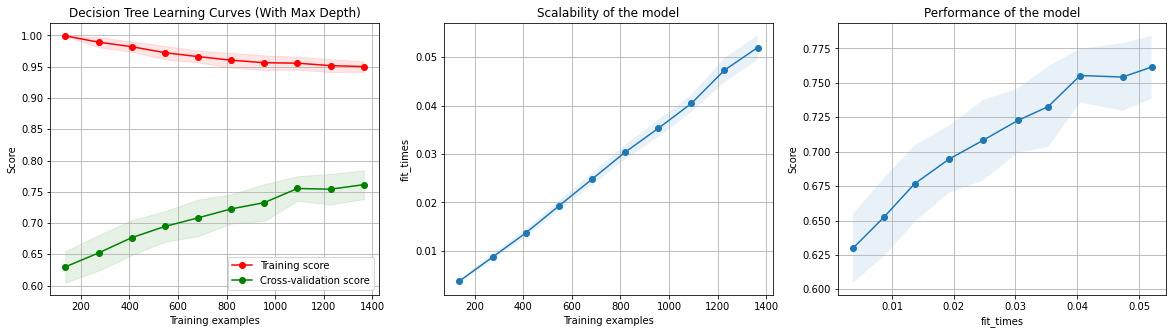

In [15]:
classifier = DecisionTreeClassifier(random_state=0, criterion='gini', 
                                    max_depth=9)
X_, y_, idx = balanced_sampling(X, y, r = 1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.3, random_state=42, stratify=y_)

title = 'Decision Tree Learning Curves (With Max Depth)'
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
plt = plot_learning_curve(classifier, title, X_train, y_train, axes=None, ylim=None, cv=cv,
                            n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10), scoring='accuracy', iterations=20,
                         undersampling=True)

a=0.0, r=1, gamma=19.758010521281683
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20


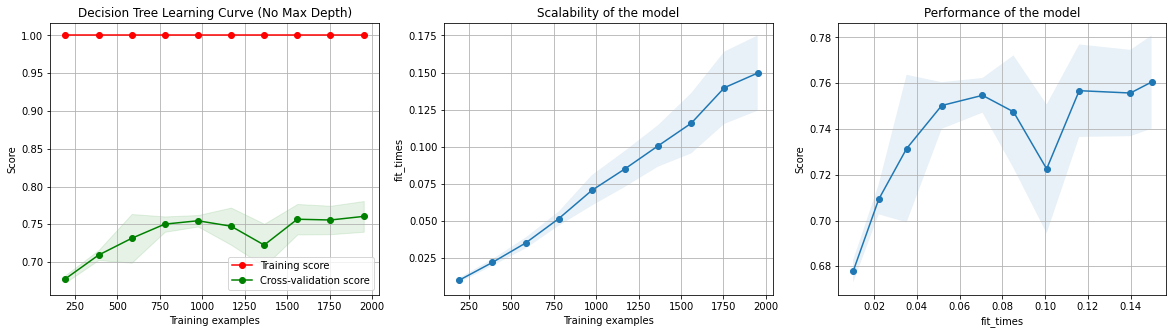

In [17]:
classifier = DecisionTreeClassifier(random_state=0, criterion='gini')
X_, y_, idx = balanced_sampling(X, y, r = 1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.3, random_state=42, stratify=y_)

title = 'Decision Tree Learning Curve (No Max Depth)'
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
plt = plot_learning_curve(classifier, title, X_train, y_train, axes=None, ylim=None, cv=cv,
                            n_jobs=8, train_sizes=np.linspace(.1, 1.0, 10), scoring='accuracy', iterations=20)

In [9]:
X_, y_, idx = balanced_sampling(X, y, r = 1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.3, random_state=42, stratify=y_)

_X_train, _X_test, _y_train, _y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)
clf = DecisionTreeClassifier(random_state=0, max_depth=9)
path = clf.cost_complexity_pruning_path(_X_train, _y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

a=0.0, r=1, gamma=19.758010521281683


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

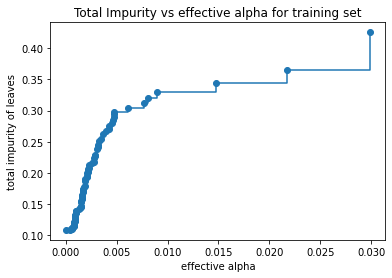

In [10]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [11]:

# reduce the granularity of ccp_alphas to speed up calculation
ccp_alphas_trimmed = [ccp_alphas[i] for i in range(0, len(ccp_alphas), 4)]
print(ccp_alphas_trimmed, len(ccp_alphas_trimmed))

[0.0, 0.0006510416666666666, 0.0008138020833333334, 0.0008519171395193611, 0.0008735069861778855, 0.0008951822916666667, 0.0009478400735294115, 0.000994910037878788, 0.0013979589950810709, 0.0015446133549798452, 0.0016276041666666667, 0.0017165221791938037, 0.0019445944215754482, 0.002101154951370466, 0.002270040833870621, 0.0027773556308544195, 0.0031336805555555554, 0.0037134677633648555, 0.004571261756899448, 0.0047590071997280214, 0.008918598835079755, 0.07447299345918673] 22


a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a

a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a

/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn

a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


a=0.0, r=1, gamma=1.0006835269993164


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn

a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164


/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jay/.virtualenv/cs7641-sl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


a=0.0, r=1, gamma=1.0006835269993164
a=0.0, r=1, gamma=1.0006835269993164


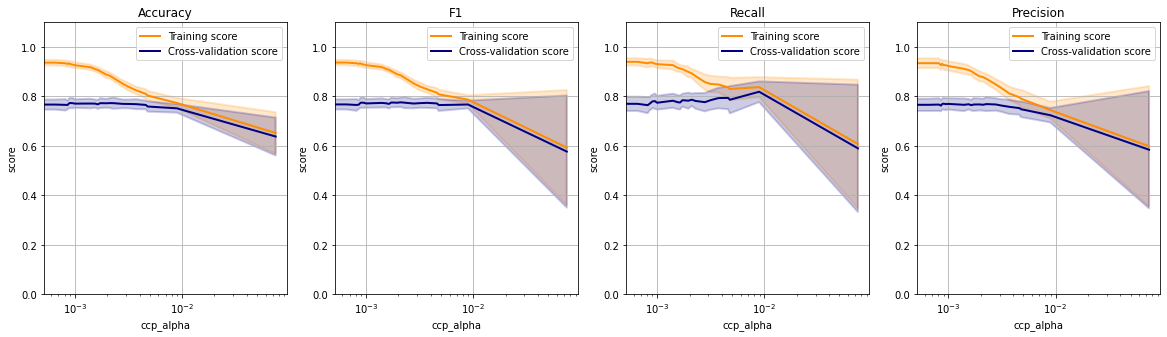

In [12]:

scoring = ['accuracy', 'f1', 'recall', 'precision']
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

classifier = DecisionTreeClassifier(random_state=0, max_depth=9)
results_store, plt = plot_validation_curve_with_undersampling(classifier, X_train, y_train, 
                  param_name='ccp_alpha', param_range=ccp_alphas_trimmed, fit_params=None, error_score='raise',
                  cv=cv, scoring=scoring, n_jobs=8, iterations=20, undersampling_ratio=1)

# print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
#       clfs[-1].tree_.node_count, ccp_alphas[-1]))

In [14]:
results_store

{'fit_time': array([[0.        , 0.14751344, 0.1100352 ],
        [0.00065104, 0.08555781, 0.00449356],
        [0.0008138 , 0.15285114, 0.10984592],
        [0.00085192, 0.11839655, 0.08174286],
        [0.00087351, 0.11492111, 0.08478139],
        [0.00089518, 0.14601508, 0.10557207],
        [0.00094784, 0.08623509, 0.00437347],
        [0.00099491, 0.15113351, 0.10993689],
        [0.00139796, 0.14984451, 0.11050238],
        [0.00154461, 0.08759638, 0.00453186],
        [0.0016276 , 0.15260071, 0.11257019],
        [0.00171652, 0.11571587, 0.07972074],
        [0.00194459, 0.12318   , 0.08111159],
        [0.00210115, 0.15248097, 0.11124545],
        [0.00227004, 0.0883263 , 0.00564865],
        [0.00277736, 0.15285963, 0.1100613 ],
        [0.00313368, 0.14934111, 0.10617048],
        [0.00371347, 0.08992712, 0.00438887],
        [0.00457126, 0.15135184, 0.10869534],
        [0.00475901, 0.14944518, 0.11097585],
        [0.0089186 , 0.08873297, 0.00659875],
        [0.07447299, 0

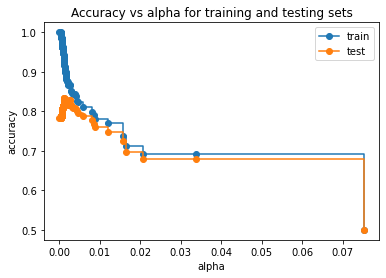

In [14]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

a=0.0, r=1, gamma=19.758010521281683
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20


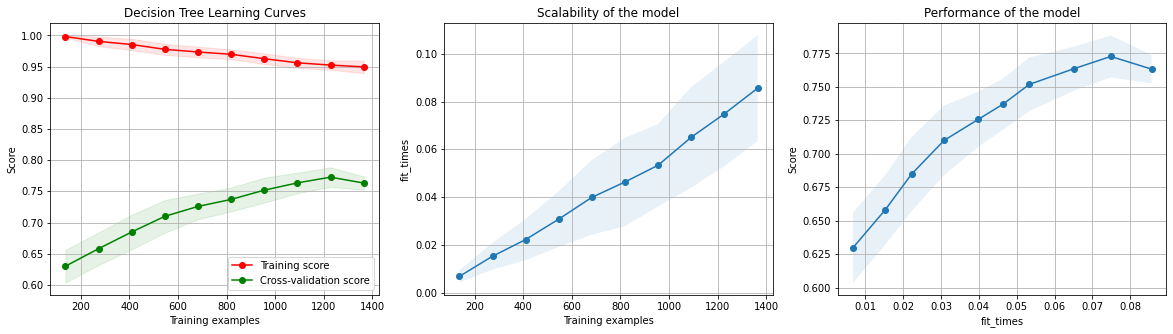

In [4]:
classifier = DecisionTreeClassifier(random_state=0, criterion='gini', max_depth=9, ccp_alpha=0.001)
X_, y_, idx = balanced_sampling(X, y, r = 1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.3, random_state=42, stratify=y_)

title = 'Decision Tree Learning Curves'
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
results = plot_learning_curve(classifier, title, X_train, y_train, axes=None, ylim=None, cv=cv,
                            n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10), scoring='accuracy', iterations=20)

In [5]:
results

{'train_sizes': array([ 136,  273,  409,  546,  682,  819,  955, 1092, 1228, 1365]),
 'train_scores_mean': array([0.99828431, 0.99047619, 0.98549307, 0.97771673, 0.97350929,
        0.96975987, 0.96273997, 0.95615079, 0.95245657, 0.94959707]),
 'train_scores_std': array([0.00172624, 0.00767271, 0.00914152, 0.00875943, 0.00851573,
        0.00790991, 0.00845851, 0.00795624, 0.00760336, 0.01000754]),
 'test_scores_mean': array([0.62992866, 0.65807382, 0.68478065, 0.70999762, 0.72580205,
        0.73710568, 0.75190169, 0.76359285, 0.77277493, 0.76330686]),
 'test_scores_std': array([0.02615283, 0.02605443, 0.0276652 , 0.02607866, 0.02054285,
        0.01910514, 0.02005178, 0.01642383, 0.01569089, 0.01060713]),
 'fit_times_mean': array([0.00678717, 0.01525122, 0.02221468, 0.03080879, 0.03988932,
        0.04637521, 0.05334245, 0.06511128, 0.07487159, 0.08561794]),
 'fit_times_std': array([0.00254695, 0.00558186, 0.00860996, 0.01168839, 0.01562256,
        0.01852089, 0.01724541, 0.02107241